## Loading Dataset

In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Loading data in pandas DataFrame
df = pd.read_excel('data.xlsx')
df.head(5).T

,0,1,2,3,4
time,2017-01-01 00:00:00,2017-01-01 00:05:00,2017-01-01 00:10:00,2017-01-01 00:15:00,2017-01-01 00:20:00
Cyclone_Inlet_Gas_Temp,867.63,879.23,875.67,875.28,891.66
Cyclone_Material_Temp,910.42,918.14,924.18,923.15,934.26
Cyclone_Outlet_Gas_draft,-189.54,-184.33,-181.26,-179.15,-178.32
Cyclone_cone_draft,-186.04,-182.1,-166.47,-174.83,-173.72
Cyclone_Gas_Outlet_Temp,852.13,862.53,866.06,865.85,876.06
Cyclone_Inlet_Draft,-145.9,-149.76,-145.01,-142.82,-143.39


## Data Preprocessing 

In [4]:
# Null value check- columnwise percentage
for column in df.columns:
    percentageNull = (df[column].isnull().sum()/df.shape[0])*100
    print(f"{column}:{percentageNull}")

time:0.0
Cyclone_Inlet_Gas_Temp:0.0
Cyclone_Material_Temp:0.0
Cyclone_Outlet_Gas_draft:0.0
Cyclone_cone_draft:0.0
Cyclone_Gas_Outlet_Temp:0.0
Cyclone_Inlet_Draft:0.0


From the above result we can conclude that the dataset doesn't have any null values.

In [5]:
#Duplicate rows check
df.duplicated().sum()

0

Neither dataset has duplicate rows.

In [6]:
#Checking data types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377719 entries, 0 to 377718
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   time                      377719 non-null  datetime64[ns]
 1   Cyclone_Inlet_Gas_Temp    377719 non-null  object        
 2   Cyclone_Material_Temp     377719 non-null  object        
 3   Cyclone_Outlet_Gas_draft  377719 non-null  object        
 4   Cyclone_cone_draft        377719 non-null  object        
 5   Cyclone_Gas_Outlet_Temp   377719 non-null  object        
 6   Cyclone_Inlet_Draft       377719 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 20.2+ MB


We can see that, except for time, all columns are of object data type, which is incorrect. They should be of float data type.

In [7]:
#Checking summary of column
df['Cyclone_Inlet_Gas_Temp'].value_counts()

Cyclone_Inlet_Gas_Temp
Not Connect    723
I/O Timeout    470
23.53          309
900.12         161
879.55         159
              ... 
554.57           1
556.18           1
1016.36          1
979.49           1
986.66           1
Name: count, Length: 39736, dtype: int64

We could explain the reason for the object data type, as the column contains strings such as 'Not Connect' and 'I/O Timeout'.

Since the string values represent a very small number of samples, we can drop them in order to convert the column's data type to float.

In [8]:
#Converting column type object to float
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = pd.to_numeric(df[column],errors='coerce')

In [9]:
#Checking summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377719 entries, 0 to 377718
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   time                      377719 non-null  datetime64[ns]
 1   Cyclone_Inlet_Gas_Temp    376399 non-null  float64       
 2   Cyclone_Material_Temp     376128 non-null  float64       
 3   Cyclone_Outlet_Gas_draft  376398 non-null  float64       
 4   Cyclone_cone_draft        376399 non-null  float64       
 5   Cyclone_Gas_Outlet_Temp   376398 non-null  float64       
 6   Cyclone_Inlet_Draft       376397 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 20.2 MB


We have successfully converted the data type of the column from object to float. However, in the process, we have imputed the dataset with null values in place of the string values, which need to be dropped.

In [10]:
df.dropna(inplace=True)

In [11]:
df.shape

(376124, 7)

Null values dropped successfully.

In [12]:
#Creating a new column for year,month
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month

## Exploratory data Analysis

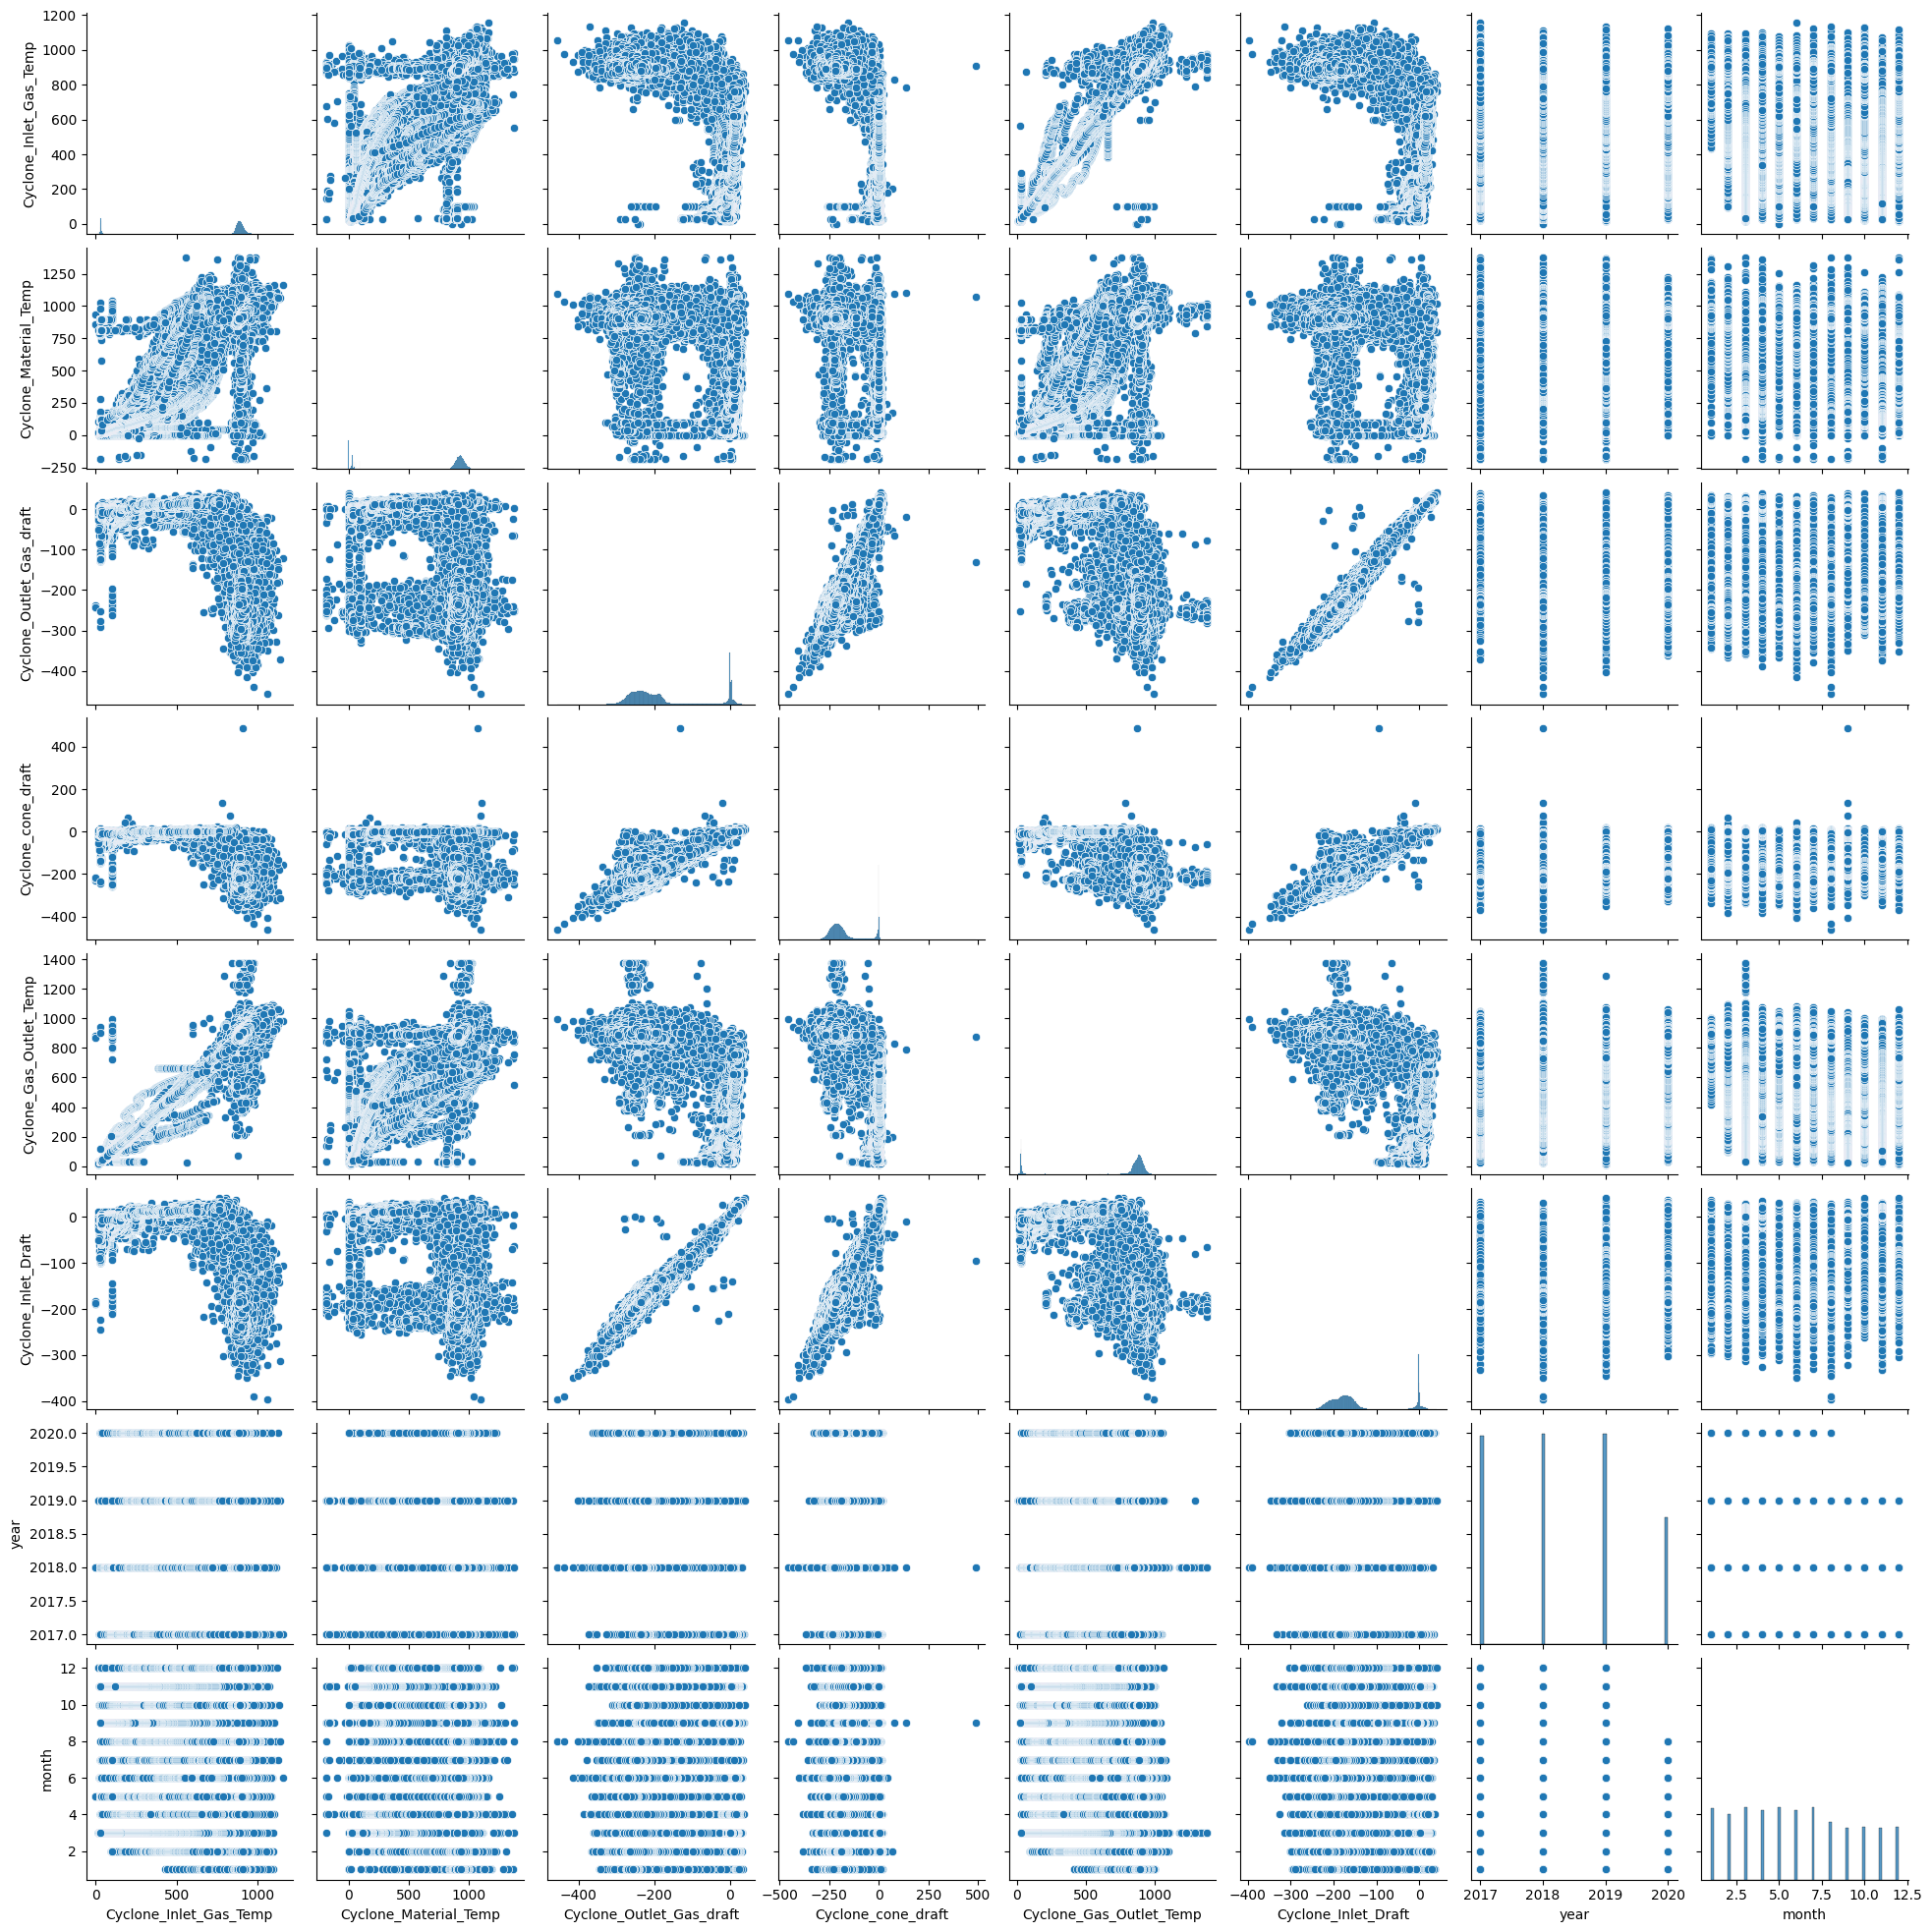

In [13]:
#Pairplot
sns.pairplot(df.drop('time',axis= 1))
plt.savefig('pairplot.png',format='png')

Here are the findings of the above pairplot-<br>
- Cyclone_Inlet_Gas_Temp & Cyclone_Gas_Outlet_Temp: Strong linear relationship, suggesting mutual influence or shared factors.

- Cyclone_Material_Temp: Scattered relationship with other temps, indicating weak direct correlation.

- Cyclone_Outlet_Gas_Draft & Cyclone_Inlet_Draft: Strong positive correlation, indicating simultaneous draft control.

- Cyclone Core Draft & Outlet Draft: Moderate correlation, suggesting a less direct influence.

- Year & Month: No strong correlation with other variables, implying minimal seasonal or annual effect.

- Clusters and Outliers: Visible in Cyclone_Gas_Outlet_Temp, possibly indicating operational modes or anomalies.

- Non-linear Patterns: Several non-linear interactions hint at complex relationships among variables.

- Outliers: Potential anomalies worth investigating for system insights or maintenance needs.

## Model Building

For finding anomalies we will be using **Isolation Forest** model.

- **Anomaly Detection**: Isolation Forest is primarily used for identifying anomalies by isolating outliers from the majority of data points.

- **Isolation by Partitioning**: It recursively partitions data by randomly selecting features and split values, isolating outliers faster as they require fewer splits.

- **Efficiency**: It's highly efficient for large datasets, as it does not require distance or density calculations, making it scalable.

- **No Assumptions on Data Distribution**: Unlike some algorithms, Isolation Forest doesn’t assume a particular distribution, making it versatile across different types of data.

- **Anomaly Score**: Each point receives an anomaly score based on how isolated it is, allowing easy classification of normal points vs. anomalies.

In [14]:
#Features used for model building
features = ['Cyclone_Inlet_Gas_Temp', 'Cyclone_Gas_Outlet_Temp', 'Cyclone_Outlet_Gas_draft', 
            'Cyclone_cone_draft', 'Cyclone_Inlet_Draft', 'Cyclone_Material_Temp']
X = df[features]

We are considering only important features for model building.

In [15]:
#We are udsng default contaminaton
model = IsolationForest()
df['anomaly'] = model.fit_predict(X)

As we don't have labeled data we cannot set exact/approximate contamination value.So I left it to default.

In [16]:
df['anomaly'].value_counts()

anomaly
 1    324436
-1     51688
Name: count, dtype: int64

Here -1 indicates anamoly.

In [18]:
df['anomaly'] = df['anomaly'].apply(lambda x:'Normal' if x == 1 else 'Anomaly')

In [20]:
# Show anomalies column-wise
num_columns = len(df.columns) - 1 
cols = 2 
rows = (num_columns + 1) // cols 

In [22]:
# Save anomalies to a new CSV file for project documentation
anomalies = df[df['anomaly'] == 'Anomaly']

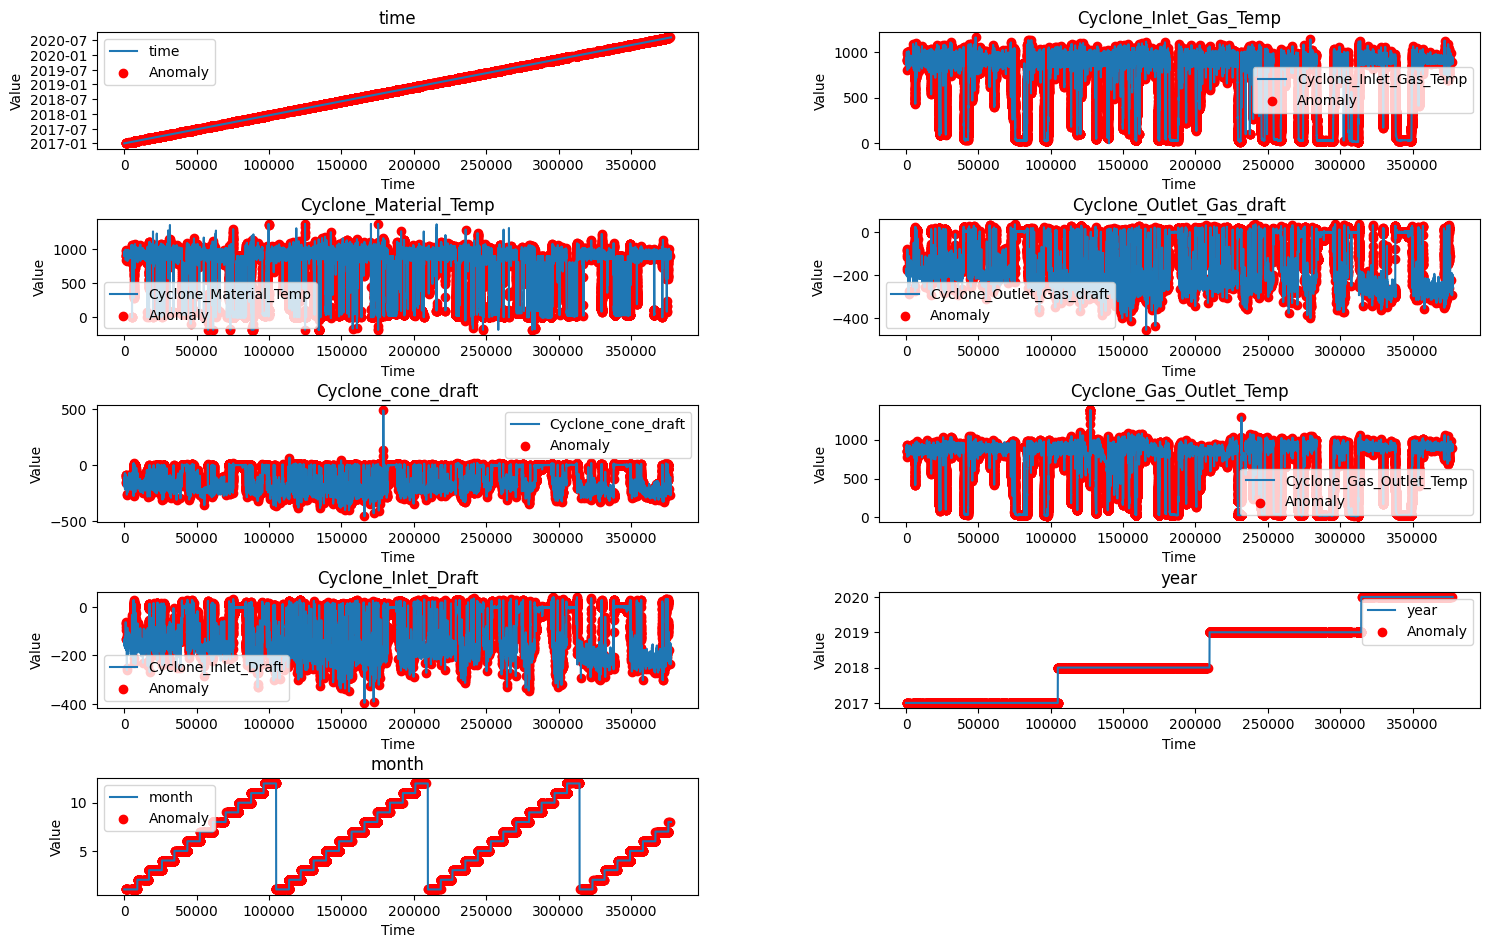

In [24]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(df.columns[:-1], 1):  
    plt.subplot(rows, cols, i)
    plt.plot(df.index, df[column], label=column)
    
    # Highlighted anomalies using red markers
    anomalies_for_column = anomalies[anomalies['anomaly'] == 'Anomaly']
    plt.scatter(anomalies_for_column.index, anomalies_for_column[column], color='red', label='Anomaly', marker='o')
    
    plt.title(f"{column}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.3, bottom=0.1)
plt.show()

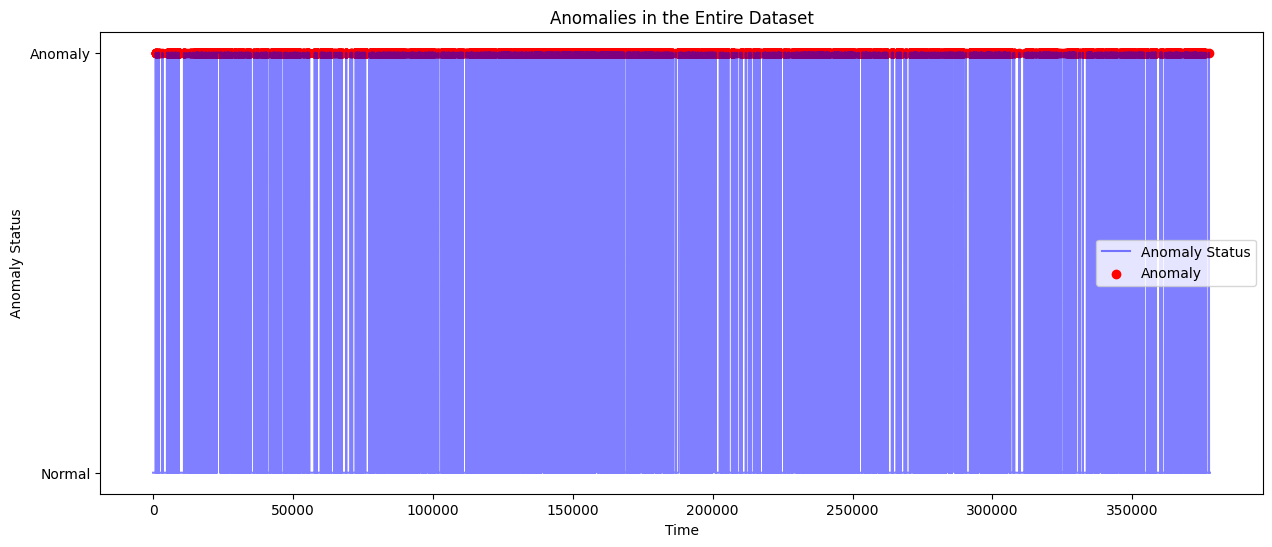

In [27]:
# Anomalies for the entire dataset (with a focus on the 'anomaly' column)
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['anomaly'], label='Anomaly Status', color='blue', alpha=0.5)

# Highlighted anomalies (red points for anomalies)
plt.scatter(anomalies.index, [1] * len(anomalies), color='red', label='Anomaly', marker='o')

plt.title("Anomalies in the Entire Dataset")
plt.xlabel("Time")
plt.ylabel("Anomaly Status")
plt.legend()
plt.show()

In [28]:
#Creating a new dataframe for anomalies
new_df = df[df['anomaly']=='Anomaly']

In [29]:
new_df

,time,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft,year,month,anomaly
930,2017-01-04 05:30:00,800.05,844.06,-87.79,-90.94,778.81,-64.97,2017,1,Anomaly
931,2017-01-04 05:35:00,909.47,897.36,-79.87,-92.26,841.75,-62.74,2017,1,Anomaly
932,2017-01-04 05:40:00,895.68,935.48,-82.56,-85.05,853.94,-68.29,2017,1,Anomaly
933,2017-01-04 05:45:00,910.73,900.23,-105.15,-104.13,848.56,-84.33,2017,1,Anomaly
934,2017-01-04 05:50:00,921.10,908.25,-116.70,-103.82,848.24,-93.53,2017,1,Anomaly
...,...,...,...,...,...,...,...,...,...,...
375433,2020-07-30 13:50:00,954.98,997.39,-132.12,-134.94,904.95,-113.93,2020,7,Anomaly
375434,2020-07-30 13:55:00,934.50,950.09,-129.70,-130.22,901.76,-105.14,2020,7,Anomaly
375943,2020-08-01 08:20:00,882.80,877.47,-108.58,-78.68,887.66,-101.10,2020,8,Anomaly
376344,2020-08-02 17:45:00,984.83,1007.36,-224.56,-210.15,977.95,-176.25,2020,8,Anomaly


In [30]:
new_df.shape

(51688, 10)

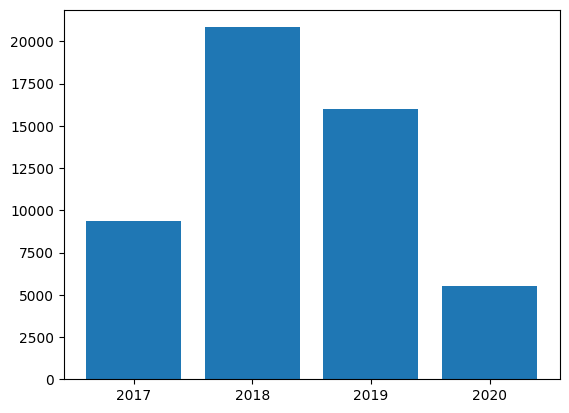

In [31]:
#Let's check year wise anamolies
yearWiseAnamolies = new_df['year'].value_counts()
plt.bar(yearWiseAnamolies.index,yearWiseAnamolies.values)
plt.xticks([2017,2018,2019,2020])
plt.show()

It is clear from above barchart the year 2018 observed most no of anomalies.Where as year 2020 observed least anomalies.

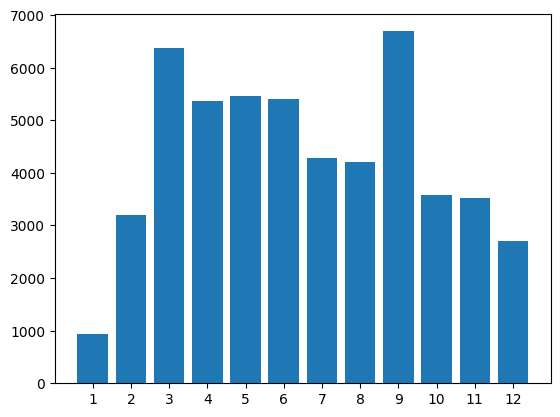

In [32]:
#Let's check Month wise anamolies
monthWiseAnamolies = new_df['month'].value_counts()
plt.bar(monthWiseAnamolies.index,monthWiseAnamolies.values)
plt.xticks(np.arange(1,13,1))
plt.show()

There is no obvious trend in month-wise anomalies. However, it is clear that the month of January has significantly fewer anomalies and month of September has most anomalies.

In [33]:
#Month wise data of anamolies.
new_df.groupby(['year','month'])[['year','month']].value_counts()

year  month
2017  1         312
      2          92
      3        1512
      4         851
      5        1002
      6         536
      7         333
      8         170
      9        1475
      10       1153
      11        828
      12       1110
2018  1         223
      2        1433
      3        1166
      4        2187
      5        2252
      6        3236
      7        2810
      8        1701
      9        2274
      10       1223
      11       1612
      12        712
2019  1         202
      2         688
      3        1979
      4        1513
      5        1557
      6        1267
      7         343
      8        2323
      9        2942
      10       1209
      11       1073
      12        887
2020  1         195
      2         978
      3        1709
      4         814
      5         648
      6         358
      7         797
      8           3
Name: count, dtype: int64

## Identifying time periods with anomalies.

In [34]:
# Difference between consecutive timestamps
new_df['interval'] = new_df['time'].diff()

In [35]:
# Setting a threshold to determine session breaks
inactivity_threshold = pd.Timedelta(minutes=5)

In [36]:
# Identify new sessions 
new_df['new_session'] = new_df['interval'] > inactivity_threshold

In [37]:
# Use cumulative sum of new sessions as session ID
new_df['session_id'] = new_df['new_session'].cumsum()

In [38]:
# Find start and end times for each session
sessions = new_df.groupby('session_id').agg(session_start=('time', 'first'), session_end=('time', 'last')).reset_index(drop=True)

In [39]:
sessions

,session_start,session_end
0,2017-01-04 05:30:00,2017-01-04 05:50:00
1,2017-01-04 06:05:00,2017-01-04 06:10:00
2,2017-01-06 23:50:00,2017-01-06 23:50:00
3,2017-01-07 00:00:00,2017-01-07 00:00:00
4,2017-01-08 05:10:00,2017-01-08 05:20:00
...,...,...
7239,2020-07-28 15:05:00,2020-07-28 15:05:00
7240,2020-07-30 10:00:00,2020-07-30 13:55:00
7241,2020-08-01 08:20:00,2020-08-01 08:20:00
7242,2020-08-02 17:45:00,2020-08-02 17:45:00


In [40]:
sessions.to_csv('Session_With_Anamolies.csv')